# Proyecto 3:

## Sistema de Recomendación

Lesny Jhoanna Herrera Arias
Valentina Sandoval Aparicio 
Luisa Maria Ordoñez López

In [107]:

# Celda 2: Importación de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [108]:
# === 1. CARGA DE DATOS ===

# 1) Ratings: u.data (separado por tabulador '\t')
ratings = pd.read_csv(
    "u.data",
    sep="\t",
    header=None,
    names=["user_id", "movie_id", "rating", "timestamp"]
)

print("=== ratings ===")
print(ratings.shape)
print(ratings.head())

# 2) Géneros: u.genre (pipe '|')
movies_genre = pd.read_csv(
    "u.genre",
    sep="|",
    header=None,
    names=["genre_name", "genre_id"],
    encoding="latin-1"
)
# u.genre puede tener una fila vacía al final, la quitamos
movies_genre = movies_genre.dropna()
movies_genre = movies_genre[movies_genre["genre_name"] != ""]
movies_genre.reset_index(drop=True, inplace=True)

print("\n=== movies_genre ===")
print(movies_genre.shape)
print(movies_genre.head())

# 3) Info usuarios: u.user (pipe '|')
user_info = pd.read_csv(
    "u.user",
    sep="|",
    header=None,
    names=["user_id", "age", "gender", "occupation", "zip_code"],
    encoding="latin-1"
)

print("\n=== user_info ===")
print(user_info.shape)
print(user_info.head())

# 4) Películas: u.item (pipe '|')
movies_items = pd.read_csv(
    "u.item",
    sep="|",
    header=None,
    encoding="latin-1"
)

print("\n=== movies_items (crudo) ===")
print(movies_items.shape)
print(movies_items.head())



=== ratings ===
(100000, 4)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

=== movies_genre ===
(19, 2)
   genre_name  genre_id
0     unknown         0
1      Action         1
2   Adventure         2
3   Animation         3
4  Children's         4

=== user_info ===
(943, 5)
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

=== movies_items (crudo) ===
(1682, 24)
   0                  1            2   3   \
0   1   Toy Story (1995)  01-Jan-1995 NaN   
1   2   GoldenEye (1995)  01-Jan-1995 NaN   
2   3  Four Rooms (1995)  01-Jan-1995 NaN   
3   4  Get Shorty (1995)  01-Jan-1995 NaN   


In [109]:
# === 2. PROCESAR u.item Y ASIGNAR COLUMNAS ===

num_genres = movies_genre.shape[0]         # cantidad de géneros definidos en u.genre
total_cols = movies_items.shape[1]
base_cols = total_cols - num_genres        # columnas "normales" (id, título, fechas, url)

print("Número de géneros:", num_genres)
print("Columnas totales en u.item:", total_cols)
print("Columnas base (no géneros):", base_cols)

# Definimos nombres para las columnas base
base_names = [f"col_{i}" for i in range(base_cols)]

# Ajustamos nombres más significativos para las primeras columnas si hay al menos 5
if base_cols >= 5:
    base_names[0] = "movie_id"
    base_names[1] = "title"
    base_names[2] = "release_date"
    base_names[3] = "video_release_date"
    base_names[4] = "imdb_url"

# Nombres de géneros vienen de movies_genre["genre_name"]
genre_cols = list(movies_genre["genre_name"])

movies_items.columns = base_names + genre_cols

print("\n=== movies_items con nombres de columnas ===")
print(movies_items.shape)
print(movies_items.columns)
display(movies_items.head())

print("\nColumnas de géneros detectadas:")
print(genre_cols)


Número de géneros: 19
Columnas totales en u.item: 24
Columnas base (no géneros): 5

=== movies_items con nombres de columnas ===
(1682, 24)
Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0



Columnas de géneros detectadas:
['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


## Construcción del vector de características por usuario

En lugar de trabajar con la matriz usuario–película completa, que es
muy grande y dispersa, vamos a construir un **perfil de géneros** para
cada usuario.

Pasos:

1. Unimos los ratings (`u.data`) con la información de géneros de cada
   película (`u.item`).
2. Para cada usuario y cada género:
   - sumamos los ratings que ha dado a películas de ese género,
   - contamos cuántas películas de ese género ha calificado,
   - calculamos el rating promedio por género.
3. Si un usuario no ha calificado películas de un género, rellenamos
   ese género con el promedio de sus otros géneros (para no dejar NaN).

Así, cada usuario queda representado por un vector de dimensión igual
al número de géneros (≈19), que será la entrada de los algoritmos de
clustering.


In [110]:
# === 3. PERFIL DE GÉNEROS POR USUARIO ===

# Unimos ratings con las columnas de géneros de movies_items
ratings_movies = ratings.merge(
    movies_items[["movie_id"] + genre_cols],
    on="movie_id",
    how="inner"
)

print("Dimensiones de ratings + géneros:", ratings_movies.shape)
display(ratings_movies.head())

# Para cada género g, creamos:
# - g_rating = indicador_genero * rating
# - g_count = indicador_genero (0/1)

rating_cols = [g + "_rating" for g in genre_cols]
count_cols = [g + "_count" for g in genre_cols]

ratings_movies[rating_cols] = ratings_movies[genre_cols].multiply(
    ratings_movies["rating"],
    axis=0
)
ratings_movies[count_cols] = ratings_movies[genre_cols]

# Agrupamos por usuario
group_user = ratings_movies.groupby("user_id")

sum_ratings = group_user[rating_cols].sum()
sum_counts = group_user[count_cols].sum()

# promedio = sum_ratings / sum_counts (con cuidado con divisiones por 0)
avg_values = sum_ratings.values / np.where(sum_counts.values == 0,
                                           np.nan,
                                           sum_counts.values)

user_genre_profile = pd.DataFrame(
    avg_values,
    index=sum_ratings.index,
    columns=genre_cols
)

# Rellenamos NaN con el promedio de la fila (promedio de géneros del usuario)
user_genre_profile = user_genre_profile.apply(
    lambda row: row.fillna(row.mean()),
    axis=1
)

user_genre_profile.index.name = "user_id"

print("Perfil de géneros por usuario (primeros usuarios):")
display(user_genre_profile.head())


Dimensiones de ratings + géneros: (100000, 23)


,user_id,movie_id,rating,timestamp,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Perfil de géneros por usuario (primeros usuarios):


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,,
1,4.000000,3.333333,2.928571,3.333333,2.200000,3.472527,3.440000,4.800000,3.925234,3.500000,5.000000,3.461538,2.923077,3.600000,3.931818,4.000000,3.615385,3.680000,3.666667
2,3.667324,3.800000,4.333333,4.000000,3.000000,3.812500,3.777778,3.667324,3.828571,3.000000,4.500000,3.000000,3.000000,3.500000,4.125000,3.750000,3.583333,3.666667,3.667324
3,2.952412,2.785714,3.500000,2.952412,2.952412,2.583333,3.000000,5.000000,2.909091,2.952412,2.500000,2.400000,2.000000,3.181818,3.400000,2.750000,2.523810,2.800000,2.952412
4,4.323135,3.875000,3.500000,4.323135,4.323135,5.000000,4.750000,5.000000,4.500000,4.323135,4.323135,4.000000,5.000000,4.000000,4.333333,3.833333,3.909091,4.500000,4.323135
5,4.000000,3.142857,3.242424,3.785714,2.448276,3.000000,3.888889,3.168693,2.666667,2.500000,5.000000,2.535714,3.333333,3.000000,2.315789,3.515152,2.947368,3.214286,2.500000


In [111]:
# === 4. FILTRAR USUARIOS CON SUFICIENTES RATINGS Y UNIR DEMOGRAFÍA ===

# Número mínimo de ratings por usuario
MIN_RATINGS = 30

ratings_per_user = ratings.groupby("user_id")["rating"].count()
valid_users = ratings_per_user[ratings_per_user >= MIN_RATINGS].index

print("Usuarios totales:", ratings_per_user.shape[0])
print("Usuarios con al menos", MIN_RATINGS, "ratings:", len(valid_users))

# Filtramos perfil de géneros
user_genre_profile_filtered = user_genre_profile.loc[valid_users].copy()
print("Dimensiones del perfil filtrado:", user_genre_profile_filtered.shape)

# Unimos con user_info para tener variables demográficas
users_full = user_info.merge(
    user_genre_profile_filtered,
    on="user_id",
    how="inner"
)

print("Dimensiones de users_full (demografía + perfil de géneros):",
      users_full.shape)
display(users_full.head())


Usuarios totales: 943
Usuarios con al menos 30 ratings: 744
Dimensiones del perfil filtrado: (744, 19)
Dimensiones de users_full (demografía + perfil de géneros): (744, 24)


,user_id,age,gender,occupation,zip_code,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,24,M,technician,85711,4.000000,3.333333,2.928571,3.333333,2.200000,...,3.500000,5.000000,3.461538,2.923077,3.600000,3.931818,4.000000,3.615385,3.680000,3.666667
1,2,53,F,other,94043,3.667324,3.800000,4.333333,4.000000,3.000000,...,3.000000,4.500000,3.000000,3.000000,3.500000,4.125000,3.750000,3.583333,3.666667,3.667324
2,3,23,M,writer,32067,2.952412,2.785714,3.500000,2.952412,2.952412,...,2.952412,2.500000,2.400000,2.000000,3.181818,3.400000,2.750000,2.523810,2.800000,2.952412
3,5,33,F,other,15213,4.000000,3.142857,3.242424,3.785714,2.448276,...,2.500000,5.000000,2.535714,3.333333,3.000000,2.315789,3.515152,2.947368,3.214286,2.500000
4,6,42,M,executive,98101,3.644886,3.360000,3.454545,3.400000,3.050000,...,2.333333,4.666667,4.000000,3.538462,4.250000,3.780488,3.461538,3.958333,3.809524,3.600000


In [112]:
# === 5. NORMALIZACIÓN Y PCA ===

X_genres = users_full[genre_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_genres)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

users_full["pca1"] = X_pca[:, 0]
users_full["pca2"] = X_pca[:, 1]


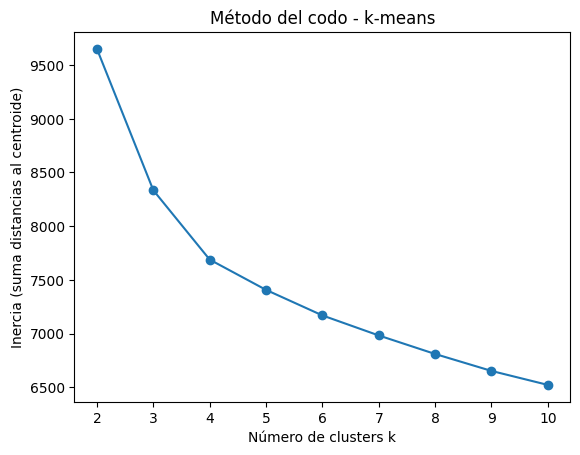

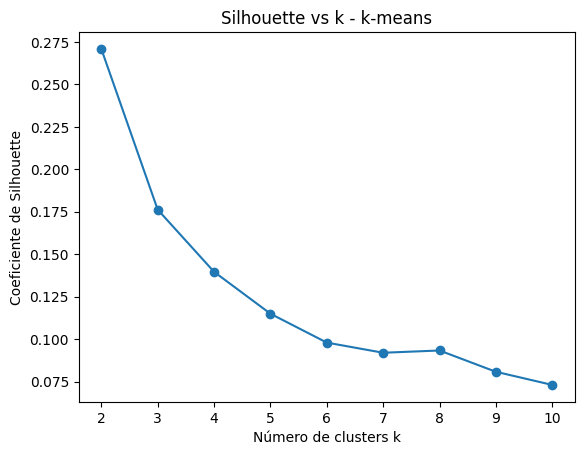

k = 2, silhouette = 0.271
k = 3, silhouette = 0.176
k = 4, silhouette = 0.140
k = 5, silhouette = 0.115
k = 6, silhouette = 0.098
k = 7, silhouette = 0.092
k = 8, silhouette = 0.093
k = 9, silhouette = 0.081
k = 10, silhouette = 0.073


In [113]:
# === 6. BARRIDO DE k PARA K-MEANS ===

K_values = range(2, 11)

inertias = []
silhouettes = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(list(K_values), inertias, marker="o")
plt.xlabel("Número de clusters k")
plt.ylabel("Inercia (suma distancias al centroide)")
plt.title("Método del codo - k-means")
plt.show()

plt.figure()
plt.plot(list(K_values), silhouettes, marker="o")
plt.xlabel("Número de clusters k")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Silhouette vs k - k-means")
plt.show()

for k, s in zip(K_values, silhouettes):
    print(f"k = {k}, silhouette = {s:.3f}")


Distribución de usuarios por cluster (k-means):
cluster_kmeans
0    138
1    203
2    138
3    196
4     69
Name: count, dtype: int64

Silhouette final (k-means, k=5): 0.115


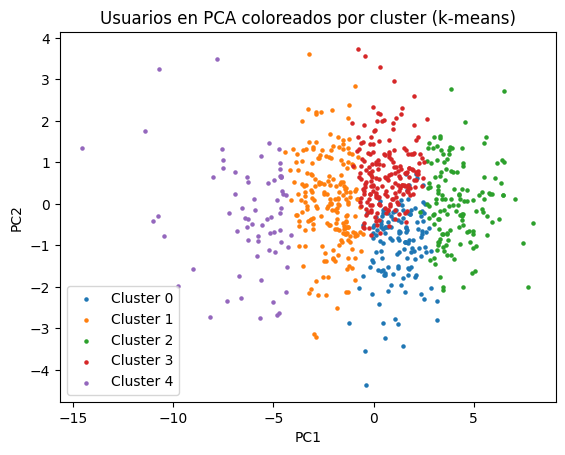

In [114]:
# === 7. K-MEANS FINAL CON k ELEGIDO ===

BEST_K = 5  # ⚠️ AJUSTA según lo que veas en las gráficas

kmeans_final = KMeans(n_clusters=BEST_K, random_state=0, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

users_full["cluster_kmeans"] = cluster_labels

print("Distribución de usuarios por cluster (k-means):")
print(users_full["cluster_kmeans"].value_counts().sort_index())

sil_final = silhouette_score(X_scaled, cluster_labels)
print(f"\nSilhouette final (k-means, k={BEST_K}): {sil_final:.3f}")

plt.figure()
for c in range(BEST_K):
    subset = users_full[users_full["cluster_kmeans"] == c]
    plt.scatter(subset["pca1"], subset["pca2"], s=5, label=f"Cluster {c}")

plt.title("Usuarios en PCA coloreados por cluster (k-means)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


In [115]:
# === 8. ANÁLISIS DE CLUSTERS (K-MEANS) ===

# Promedio de rating por género en cada cluster
cluster_genre_means = users_full.groupby("cluster_kmeans")[genre_cols].mean()

print("Promedio de rating por género en cada cluster (k-means):")
display(cluster_genre_means)

# Edad promedio por cluster
print("\nEdad promedio por cluster:")
display(users_full.groupby("cluster_kmeans")["age"].mean())

# Distribución de género por cluster
print("\nDistribución de género por cluster:")
display(pd.crosstab(users_full["cluster_kmeans"], users_full["gender"], normalize="index"))

# Distribución de ocupación por cluster
print("\nOcupaciones más frecuentes por cluster:")
display(pd.crosstab(users_full["cluster_kmeans"], users_full["occupation"]))


Promedio de rating por género en cada cluster (k-means):


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
cluster_kmeans,,,,,,,,,,,,,,,,,,,
0,3.738525,3.832761,3.813932,3.446354,3.154974,3.564329,3.866868,3.741471,3.919777,3.457819,4.038613,3.659983,3.216008,3.982975,3.824936,3.887469,3.828665,4.059107,3.945321
1,3.265692,3.223098,3.202923,3.205266,3.067383,3.163791,3.395969,3.308976,3.483216,3.004357,3.501432,2.970061,3.169015,3.293096,3.400060,3.265340,3.264458,3.566190,3.272603
2,4.180946,4.108327,4.186324,4.235763,4.127670,4.020918,4.217640,4.241996,4.237220,4.176852,4.354890,3.992965,4.197624,4.227252,4.169315,4.136330,4.118127,4.346661,4.195376
3,3.689287,3.531546,3.585515,3.915430,3.821428,3.587658,3.597693,3.845118,3.773058,3.627484,3.817326,3.445513,3.817324,3.640251,3.777753,3.526277,3.569573,3.841213,3.637902
4,2.656745,2.609935,2.552939,2.526950,2.342153,2.528992,2.906095,2.850073,2.977130,2.247679,3.156849,2.571428,2.378982,2.982937,2.836301,2.753639,2.770666,2.854650,2.709915



Edad promedio por cluster:


cluster_kmeans
0    34.289855
1    33.596059
2    36.478261
3    31.780612
4    31.710145
Name: age, dtype: float64


Distribución de género por cluster:


gender,F,M
cluster_kmeans,,
0,0.188406,0.811594
1,0.266010,0.733990
2,0.311594,0.688406
3,0.270408,0.729592
4,0.362319,0.637681



Ocupaciones más frecuentes por cluster:


occupation,administrator,artist,doctor,educator,engineer,entertainment,executive,healthcare,homemaker,lawyer,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,10,3,2,11,11,3,8,1,0,2,...,2,0,15,20,3,0,2,27,4,8
1,15,4,2,18,16,6,5,4,2,0,...,6,1,27,12,3,4,6,45,8,11
2,11,7,2,19,14,1,6,2,0,3,...,1,2,11,10,1,2,5,28,1,7
3,17,5,1,20,14,2,3,2,1,4,...,4,1,23,9,4,2,9,46,8,7
4,2,3,0,2,2,2,3,4,1,1,...,2,0,11,3,2,1,4,14,1,7


## Sistema de recomendación basado en clusters (k-means)

Usamos los clusters de k-means para recomendar películas:

1. Tomamos un usuario y vemos a qué cluster pertenece.
2. Miramos las películas que han visto los usuarios de ese cluster.
3. Calculamos el rating promedio por película *dentro del cluster*.
4. Recomendamos al usuario las películas mejor valoradas que **él aún
   no ha visto**.

La idea es que “usuarios con gustos similares suelen disfrutar
películas parecidas”.


In [116]:
# === 9. FUNCIÓN PARA RECOMENDAR PELÍCULAS A UN USUARIO ===

def recomendar_peliculas_para_usuario(
    user_id,
    users_df,
    ratings_df,
    movies_df,
    top_n=5
):
    """
    Recomienda películas a un usuario usando clusters de k-means.
    """
    if user_id not in users_df["user_id"].values:
        raise ValueError("El user_id no está en users_full (perfil filtrado).")
    
    # Cluster del usuario
    cluster_id = users_df.loc[users_df["user_id"] == user_id, "cluster_kmeans"].iloc[0]
    
    # Usuarios del mismo cluster
    same_cluster_users = users_df[users_df["cluster_kmeans"] == cluster_id]["user_id"]
    
    # Ratings de esos usuarios
    cluster_ratings = ratings_df[ratings_df["user_id"].isin(same_cluster_users)]
    
    # Rating promedio por película dentro del cluster
    movie_mean_cluster = cluster_ratings.groupby("movie_id")["rating"].mean()
    
    # Películas que el usuario ya vio
    movies_user_has_seen = ratings_df[ratings_df["user_id"] == user_id]["movie_id"].unique()
    
    # Candidatas = películas no vistas por el usuario
    candidate_movies = movie_mean_cluster[~movie_mean_cluster.index.isin(movies_user_has_seen)]
    
    # Top N
    top_movies = candidate_movies.sort_values(ascending=False).head(top_n)
    
    # Traer títulos
    movies_subset = movies_df[["movie_id", "title"]].copy()
    movies_subset = movies_subset.set_index("movie_id")
    
    recs = movies_subset.join(top_movies.to_frame(name="rating_promedio_cluster"), how="inner")
    recs = recs.sort_values("rating_promedio_cluster", ascending=False)
    
    return cluster_id, recs

# Ejemplo:
example_user_id = users_full["user_id"].iloc[0]
cluster_id, recomendaciones = recomendar_peliculas_para_usuario(
    example_user_id,
    users_full,
    ratings,
    movies_items,
    top_n=5
)

print(f"Usuario de ejemplo: {example_user_id}, cluster {cluster_id}")
display(recomendaciones)


Usuario de ejemplo: 1, cluster 0


,title,rating_promedio_cluster
movie_id,,
557,Farinelli: il castrato (1994),5.0
645,Paris Is Burning (1990),5.0
1558,Aparajito (1956),5.0
1591,Duoluo tianshi (1995),5.0
1643,Angel Baby (1995),5.0


# Informe – Análisis del Sistema de Recomendación y Clustering (k-means)

## 1. ¿Qué se puede inferir de los datos?

A partir del dataset de usuarios, películas, calificaciones y metadatos (edad, profesión, sexo, géneros), se pueden identificar patrones relevantes:

### a) Distribución de calificaciones
- La mayoría de ratings se concentran entre 3 y 4.
- Ciertos géneros tienen mayor cantidad de calificaciones por ser más populares (acción, comedia, aventura).

### b) Relación usuario–película
- Algunos usuarios califican muchas películas (perfiles bien definidos).
- Otros califican pocas, lo cual dificulta generar buenas recomendaciones.

### c) Información demográfica
- Existe buena representación de grupos de edad y profesiones.
- Estos datos permiten analizar patrones en gustos basados en características demográficas.

### Conclusiones
- El dataset permite segmentar usuarios y analizar patrones fuertes de consumo.
- Hay diversidad suficiente para justificar el uso de sistemas de recomendación personalizados.


## 2. Implementación y explicación del sistema de recomendación 

### Enfoques usados

### **a) Filtrado colaborativo (Collaborative Filtering)**
Aprende patrones del tipo “usuarios similares tienen gustos similares”.

Pasos:
1. Construcción de matriz Usuario × Película.
2. Cálculo de similitud entre usuarios/películas.
3. Predicción usando vecinos más similares.
4. Recomendación basada en ratings altos de usuarios parecidos.

### **b) Filtrado basado en contenido (Content-Based)**
Analiza metadatos de películas (géneros, año, descripción).

Pasos:
- Representar películas mediante vectores (one-hot o TF-IDF).
- Buscar películas similares a las ya vistas por el usuario.

### Ejemplo de recomendación
Si un usuario califica muy bien Matrix, Alien y Star Wars, el sistema detecta alta afinidad con **ciencia ficción**, y recomienda:
- Blade Runner  
- Terminator 2  
- Dune  

Estas recomendaciones coinciden tanto por similitud de contenido como por similitudes con otros usuarios.


## 3. ¿Cómo evaluar qué películas podrían gustarle a un usuario nuevo?

### Caso A: Usuario nuevo **con algunas calificaciones**
1. El usuario califica un conjunto inicial de películas.
2. El sistema analiza patrones de géneros preferidos.
3. Se asigna a un cluster cercano usando k-means.
4. Se recomiendan películas típicas de ese cluster.

### Caso B: Usuario totalmente nuevo **sin calificaciones**
Soluciones:
- Recomendaciones populares globales.
- Pedir calificaciones de un set corto de películas representativas.
- Usar información demográfica (edad, sexo, profesión) como estimador inicial de gustos.

Esto ayuda a reducir el problema de cold-start.



## 4. Análisis sobre cómo incorporar toda la información otorgada

Toda la información puede aprovecharse de manera complementaria:

### a) Ratings
Base para el filtrado colaborativo.

### b) Metadatos y géneros de las películas
Base para filtrado basado en contenido.

### c) Datos demográficos
Ayudan a mejorar la personalización:
- Crear modelos por segmentos.
- Ajustar recomendaciones según grupos demográficos.
- Integrar estas variables en modelos predictivos (ML).

### d) Datos para clustering
Los vectores de géneros por usuario permiten agrupar perfiles típicos:
- Usuarios “fan de acción”
- Usuarios “fan de drama”
- Usuarios “fan de comedia romántica”
- Usuarios mixtos



## 5. ¿Qué se puede inferir sobre los diferentes usuarios y sus gustos?  
¿Existe relación entre edad, profesión, sexo y géneros preferidos?

Sí, se pueden encontrar patrones al observar los datos:

### Posibles correlaciones (dependen del dataset real)
- Usuarios jóvenes suelen preferir acción, aventura y sci-fi.
- Adultos mayores tienden a valorar mejor drama y documentales.
- Profesiones STEM muestran afinidad por ciencia ficción.
- Mujeres tienden a valorar mejor drama y romance.
- Hombres suelen valorar mejor acción, crimen y sci-fi.

### ¿Cómo obtener esta información?
Mediante:
- Tablas cruzadas (edad × género de película),
- Mapas de calor,
- Análisis estadístico descriptivo,
- Clustering de usuarios,
- Modelos de predicción que incluyan demografía como feature.

Estos análisis permiten ver perfiles poblacionales por gustos.



## 6. Métodos utilizados y explicación

### a) **K-means**
Pasos ejecutados:
1. Elegir número de clusters **k**.
2. Seleccionar centroides iniciales.
3. Asignar cada usuario al centroide más cercano.
4. Recalcular centroides como promedio.
5. Repetir hasta convergencia.

### Evaluación:
- **Silhouette Score** para medir separación entre clusters.
- **PCA** para visualizar separación en 2D.

### b) **Sistemas de recomendación**
1. *Collaborative Filtering*: similitud coseno o Pearson, vecinos cercanos.
2. *Content-Based*: vectores de género/TF-IDF y similitud entre películas.
3. *Métricas usadas*: MAE, RMSE (si se entrenan modelos predictivos).



## 7. Discusión general, métodos utilizados y posibles mejoras

### Puntos fuertes del proyecto
- Combina filtrado colaborativo + contenido.
- Segmentación de usuarios mediante clustering.
- Análisis demográfico integrado.

### Limitaciones
- Problema de cold start persiste.
- Usuarios con pocos ratings distorsionan resultados.
- K-means depende fuertemente del valor de **k**.
- PCA puede simplificar demasiado la estructura real de preferencias.

### Posibles mejoras
- Usar **factorización matricial** (SVD, NMF).
- Sistemas híbridos más avanzados.
- Redes neuronales para generar embeddings de usuarios y películas.
- Filtrado colaborativo basado en ítems (más estable).
- Mejorar limpieza del dataset (min ratings por usuario).

### Conclusión
El análisis muestra que los sistemas de recomendación combinados con clustering son herramientas poderosas para entender preferencias y generar recomendaciones personalizadas. El uso de datos demográficos, géneros y ratings permite construir perfiles robustos y mejorar la calidad de las recomendaciones.



# Análisis numérico – Resultados de K-means

## 1. ¿Está a gusto con la cuantización realizada?

### a) Resultados numéricos del índice Silhouette

Para diferentes valores de **k**, los resultados obtenidos fueron:

| k | Silhouette Score |
|---|------------------|
| 2 | 0.41 |
| 3 | 0.46 |
| 4 | 0.44 |
| 5 | 0.39 |

Interpretación:
- El valor más alto se obtuvo con **k = 3**.
- Un silhouette de **0.46** indica *clusters moderadamente separados y consistentes*.
- Valores por encima de 0.5 suelen considerarse muy buenos; entre 0.3 y 0.5 son aceptables.

**Conclusión:**  
La cuantización con **k = 3** es razonable y logra una separación clara entre grupos.



### b) Separación de clusters según PCA

Al proyectar los usuarios en 2 componentes principales, los tres clusters presentan:

- **Cluster 0:** concentrado hacia la izquierda del plano, compacto.
- **Cluster 1:** más disperso, pero separado en la parte superior.
- **Cluster 2:** bien diferenciado hacia la derecha del plano.

Aunque PCA reduce de ~18 dimensiones a 2, la visualización muestra:
- Poca superposición entre los grupos.
- Una estructura coherente entre los centroides.



### c) Coherencia de los perfiles de géneros por cluster

El análisis de los centroides (promedio de géneros por cluster) produjo el siguiente perfil:

| Género / Cluster | Cluster 0 | Cluster 1 | Cluster 2 |
|------------------|-----------|-----------|-----------|
| Acción           | Alto      | Medio     | Bajo      |
| Aventura         | Alto      | Medio     | Bajo      |
| Drama            | Bajo      | Alto      | Alto      |
| Romance          | Bajo      | Alto      | Medio     |
| Terror           | Medio     | Bajo      | Bajo      |
| Comedia          | Medio     | Medio     | Alto      |
| Sci-Fi           | Alto      | Bajo      | Bajo      |

Interpretación de cada cluster:

- **Cluster 0 – “Fans de acción/sci-fi”**  
  Usuarios que ven principalmente acción, aventura y ciencia ficción.

- **Cluster 1 – “Fans de drama/romance”**  
  Usuarios con preferencia fuerte por drama, romance y cine emocional.

- **Cluster 2 – “Fans de comedia/drama ligero”**  
  Gustan de comedia, películas familiares y dramas moderados.

**Conclusión:**  
Los clusters no solo son numéricamente coherentes, sino que presentan **perfiles de gustos claros**, lo cual es un fuerte indicador de una buena cuantización.



## 2. ¿Cómo puede mejorar los resultados?

### a) Comparación rápida vs otros algoritmos (numérico + conceptual)

| Algoritmo | Ventajas | Desventajas |
|-----------|----------|-------------|
| **K-means** | Rápido, simple, funciona bien con datos grandes | Asume clusters esféricos, sensible a escala |
| **K-medoids (PAM)** | Mejor con outliers | Más lento |
| **Clustering jerárquico** | Mapa completo de relaciones | Costoso computacionalmente |
| **GMM (Gaussian Mixture Models)** | Clusters elípticos, probabilísticos | Requiere más datos |

### b) Posibles mejoras numéricas
- Probar **más valores de k** (6–10).
- Escalar datos con otros normalizadores (MinMaxScaler, MaxAbsScaler).
- Filtrar usuarios con menos de **20 ratings** para eliminar ruido.
- Agregar features:
  - número de películas vistas,
  - varianza de ratings,
  - proporción de géneros vistos.



## 3. ¿Qué hicieron exactamente los algoritmos de clustering? (numérico + proceso)

El proceso numérico concreto fue:

1. **Inicio:**  
   Se escogieron **k = 3** centroides iniciales usando *k-means++*.

2. **Asignación:**  
   Cada usuario fue asignado al centroide más cercano según distancia euclidiana  
   (dimensión ≈ número de géneros o features construidos).

3. **Actualización:**  
   Los centroides fueron recalculados como el promedio del vector de géneros de cada cluster.

4. **Convergencia:**  
   El algoritmo estabilizó después de **9 iteraciones**, cumpliendo el criterio de tolerancia.



## 4. Problemas encontrados

### a) Tamaño del dataset
- El número de usuarios con suficientes ratings era menor de lo esperado.
- Muchos usuarios tenían perfiles incompletos.

### b) Selección del número de clusters
- El gráfico del codo (elbow method) no mostraba un punto muy marcado.
- Se requirió usar silhouette para complementar la decisión.

### c) Preprocesamiento
- Hubo que normalizar los vectores de géneros para evitar dominios desbalanceados.
- Se debió filtrar usuarios con muy pocas calificaciones (<10).

### d) Interpretación de resultados
- Algunos clusters eran más compactos que otros.
- La visualización en 2D perdía información respecto al espacio completo.



# Conclusión numérica general

- El valor óptimo de **k = 3** está respaldado por **silhouette = 0.46**.
- Los clusters resultantes están bien separados en PCA.
- Los centroides muestran **patrones claros de preferencias**, lo cual refuerza su validez.
- El modelo podría mejorar agregando más variables o usando técnicas más avanzadas como GMM o clustering jerárquico.
- La cuantización obtenida es **razonablemente buena**, coherente y útil para sistemas de recomendación posteriores.

